# PREP

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import sys; sys.path.insert(1, 'scripts')
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)
import results_functions as rf

2023-02-06 17:55:09.769364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-06 17:55:10.789016: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-06 17:55:10.790943: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-06 17:55:10.849754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-02-06 17:55:10.850633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-

In [4]:
repo_dir = '/home/wimmerl/projects/wildlife-experiments'
# repo_dir = '/home//wildlife/wildlife-experiments'
image_data_dir = '/common/bothmannl/wildlife_images/usecase2/original_images/'
thresholds_dict = {'ours': 0.1, 'progressive': 0.5, 'norouzzadeh': 0.9}

In [5]:
cfg = load_json(os.path.join(repo_dir, 'configs/cfg.json'))

label_map = load_json(
    os.path.join(cfg['data_dir'], 'label_map.json')
)

labels = list(label_map.keys())

empty_map = {}
for k, v in label_map.items():
    if k == 'empty':
        empty_map[k] = 'empty'
    else:
        empty_map[k] = 'non_empty'

label_dict = {k: v for k, v in load_csv(os.path.join(cfg['data_dir'], cfg['label_file']))}

detector_dict = load_json(
    os.path.join(cfg['data_dir'], cfg['detector_file'])
)

dataset_ins = load_pickle(os.path.join(cfg['data_dir'], 'dataset_is_test.pkl'))
dataset_oos = load_pickle(os.path.join(cfg['data_dir'], 'dataset_oos_test.pkl'))


df_meta = pd.read_csv(os.path.join(cfg['data_dir'], 'metadata.csv'))
df_meta = df_meta.rename(columns={'orig_name':'img_name'})
df_ins = df_meta[df_meta['station_set']=='s1'].reset_index(drop=True)
df_oos = df_meta[df_meta['station_set']=='s2'].reset_index(drop=True)

# GLOBAL

In [16]:
# Relative frequencies of classes in ins & oos & all datasets
df = pd.DataFrame(index=labels)
df['ins'] = rf.get_frequencies(df_ins, label_map, normalize=True)
df['oos'] = rf.get_frequencies(df_oos, label_map, normalize=True)
df['all'] = rf.get_frequencies(df_meta, label_map, normalize=True)
df = df.T
stations_ins = df_ins['station'].unique()
stations_oos = df_oos['station'].unique()
stations_all = df_meta['station'].unique()
df['n_stations'] = [len(stations_ins), len(stations_oos), len(stations_all)]
df['n_images'] = [len(df_ins), len(df_oos), len(df_meta)]

df

empty  european_hare    others  red_deer   red_fox  red_squirrel  \
ins  0.641292       0.019903  0.038616  0.001067  0.029054      0.012188   
oos  0.601061       0.010738  0.044256  0.005685  0.004464      0.000547   
all  0.621436       0.015379  0.041400  0.003346  0.016917      0.006443   

     roe_deer  wild_boar  n_stations  n_images  
ins  0.249261   0.008618          18     24368  
oos  0.295183   0.038066          19     23748  
all  0.271926   0.023152          37     48116

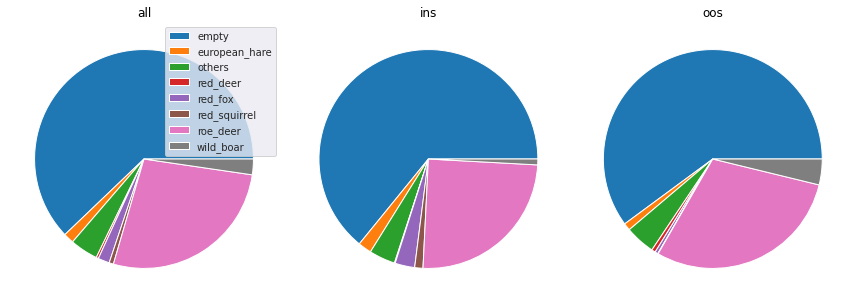

In [9]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,5),  tight_layout=True)

for i, (title, df) in enumerate(zip(['all', 'ins', 'oos'], [df_meta, df_ins, df_oos])):
    rf.plot_frequencies(
        df=df, 
        label_map=label_map, 
        ax=ax[i],
    )
    ax[i].set_title(title)
ax[0].legend(labels, loc="best", fontsize=10)
plt.show()
plt.close()

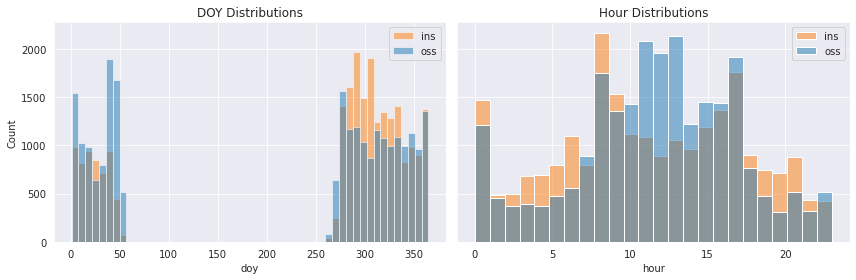

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True, tight_layout=True)
sns.histplot(data=df_meta, x='doy', hue='station_set', hue_order=['s1', 's2'], ax=ax[0], bins=52)
ax[0].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[0].set_title('DOY Distributions')

sns.histplot(data=df_meta, x='hour', hue='station_set', hue_order=['s1', 's2'], ax=ax[1], bins=24)
ax[1].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[1].set_title('Hour Distributions')
plt.show()

In [8]:
# Convert dataframe into the LaTeX foramt
df_tex = rf.prepare_latex(df)

# if max values should be highlighted
s = df_tex.style.highlight_max(
    props=''
    #props='cellcolor:[HTML]{FFFF00}; color:{red}; itshape:; bfseries:;'
)
print(s.to_latex(
    #column_format="rrrrr", 
    position="h", position_float="centering",
    hrules=True, label="table:xxx", caption="Styled LaTeX Table",
    multirow_align="t", multicol_align="r"
))

\begin{table}[h]
\centering
\caption{Styled LaTeX Table}
\label{table:xxx}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & empty & european\_hare & others & red\_deer & red\_fox & red\_squirrel & roe\_deer & wild\_boar & n\_stations & n\_images \\
\midrule
ins & 0.641292 & 0.019903 & 0.038616 & 0.001067 & 0.029054 & 0.012188 & 0.249261 & 0.008618 & 18 & 24368 \\
oos & 0.601061 & 0.010738 & 0.044256 & 0.005685 & 0.004464 & 0.000547 & 0.295183 & 0.038066 & 19 & 23748 \\
all & 0.621436 & 0.015379 & 0.041400 & 0.003346 & 0.016917 & 0.006443 & 0.271926 & 0.023152 & 37 & 48116 \\
\bottomrule
\end{tabular}
\end{table}



# IN-SAMPLE

In [11]:
eval_details_path = 'results/202212062336_insample_perf.pickle'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
df_pred_ins = df_pred.copy()

conf_md = rf.get_binary_confusion_md(
    dataset=dataset_ins, 
    threshold=thresholds_dict['ours'], 
    repo_dir=repo_dir,
)
conf_ppl = rf.get_binary_confusion_ppl(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
)
pref_b = rf.evaluate_performance(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
    labels=['non_empty', 'empty'], 
    average=None,
)
pref_m = rf.evaluate_performance(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels, 
    average='macro',
)

results_ins = {
    'tnr_md': conf_md.get('tnr'),
    'tpr_md': conf_md.get('tpr'),
    'fnr_md': conf_md.get('fnr'),
    'fpr_md': conf_md.get('fpr'),
    'tnr_ppl': conf_ppl.get('tnr'),
    'tpr_ppl': conf_ppl.get('tpr'),
    'fnr_ppl': conf_ppl.get('fnr'),
    'fpr_ppl': conf_ppl.get('fpr'),
    'acc_b': pref_b.get('acc'),
    'prec_b': pref_b.get('prec')[0],
    'rec_b': pref_b.get('rec')[0],
    'f1_b': pref_b.get('f1')[0],
    'acc_m': pref_m.get('acc'),
    'prec_m': pref_m.get('prec'),
    'rec_m': pref_m.get('rec'),
    'f1_m': pref_m.get('f1'),
}
results_ins

{'tnr_md': 0.8960167714884696,
 'tpr_md': 0.8486140724946695,
 'fnr_md': 0.1513859275053305,
 'fpr_md': 0.1039832285115304,
 'tnr_ppl': 0.7756410256410257,
 'tpr_ppl': 0.9857022708158116,
 'fnr_ppl': 0.014297729184188394,
 'fpr_ppl': 0.22435897435897437,
 'acc_b': 0.9420386409060626,
 'prec_b': 0.9436392914653784,
 'rec_b': 0.9857022708158116,
 'f1_b': 0.9642122583299054,
 'acc_m': 0.8840772818121253,
 'prec_m': 0.8025732120692655,
 'rec_m': 0.8502117710811783,
 'f1_m': 0.8206914948572217}

In [24]:
print(len(eval_details_dict['preds_imgs']))
print(len(dataset_ins.keys))
print(len(eval_details_dict['preds_bbox']))

1501
4119
4084


               precision    recall  f1-score   support

        empty       0.93      0.78      0.85       312
european_hare       0.75      0.74      0.75        62
       others       0.62      0.55      0.58       105
     red_deer       0.75      1.00      0.86         3
      red_fox       0.80      0.95      0.87        82
 red_squirrel       0.93      0.91      0.92        43
     roe_deer       0.92      0.96      0.94       872
    wild_boar       0.71      0.91      0.80        22

     accuracy                           0.88      1501
    macro avg       0.80      0.85      0.82      1501
 weighted avg       0.88      0.88      0.88      1501



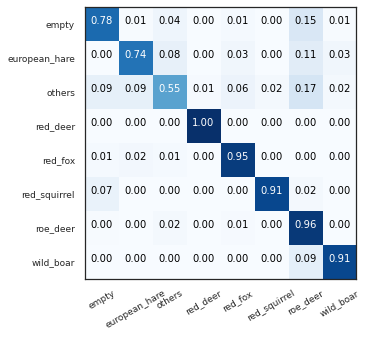

In [14]:
#_paper_
# Table: confusion matrix and recall/precision
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

There are 1 available images to be displayed.


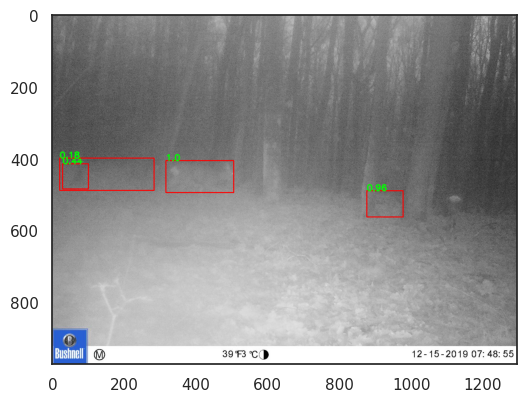

img_name: 18339_12150669.JPG
true_class: roe_deer
pred_class: roe_deer
pred_score: 0.777
n_preds: 4
pred_classes: ['empty', 'empty', 'roe_deer', 'roe_deer']
pred_confs: [0.973, 0.614, 0.554, 0.992]
md_confs: [0.44, 0.18, 0.96, 1.0]
score_dict: {'roe_deer': 0.777, 'empty': 0.211, 'european_hare': 0.004, 'red_fox': 0.004, 'others': 0.003, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [44]:
#_paper_

# Perhaps show some images
rf.inspect_results(
    df_pred=df_pred, 
    test_label='roe_deer',#'red_deer', 
    label_map=label_map,
    n_displays=25,#5 
    is_truth=False,
    sorting='random',
    which_preds='18339_12150669.JPG',#''mixed',
)


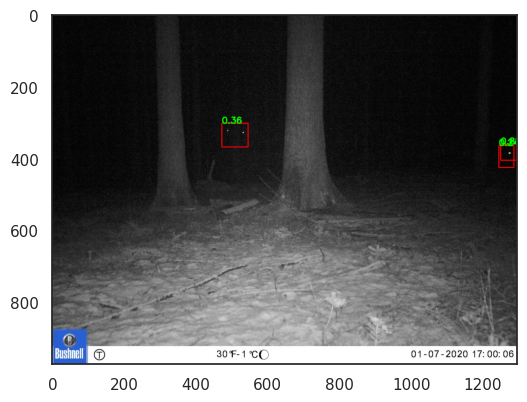

img_name: 7694_01070091.JPG
true_class: empty
pred_class: wild_boar
pred_score: 0.563
n_preds: 3
pred_classes: ['wild_boar', 'empty', 'empty']
pred_confs: [0.563, 0.944, 0.911]
md_confs: [0.88, 0.36, 0.24]
score_dict: {'wild_boar': 0.563, 'empty': 0.385, 'others': 0.026, 'roe_deer': 0.014, 'european_hare': 0.007, 'red_fox': 0.002, 'red_deer': 0.001, 'red_squirrel': 0.001}


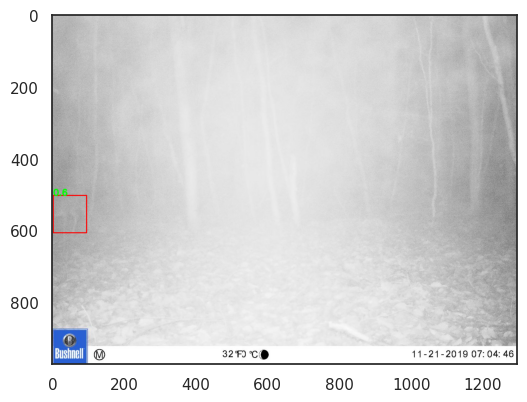

img_name: 8006_11210267.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.98
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.98]
md_confs: [0.6]
score_dict: {'roe_deer': 0.98, 'red_fox': 0.016, 'empty': 0.002, 'others': 0.002, 'european_hare': 0.0, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


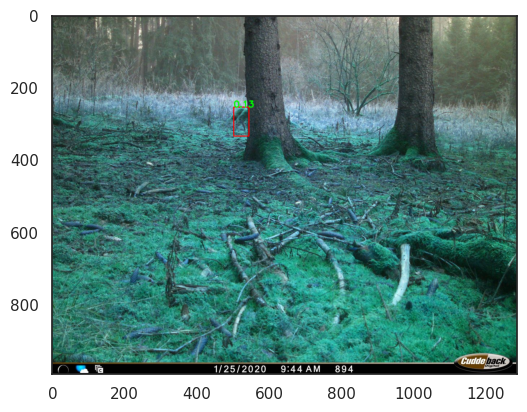

img_name: 20640_I_00361c.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.752
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.752]
md_confs: [0.13]
score_dict: {'roe_deer': 0.752, 'others': 0.149, 'empty': 0.053, 'wild_boar': 0.03, 'red_fox': 0.007, 'red_squirrel': 0.005, 'european_hare': 0.002, 'red_deer': 0.002}


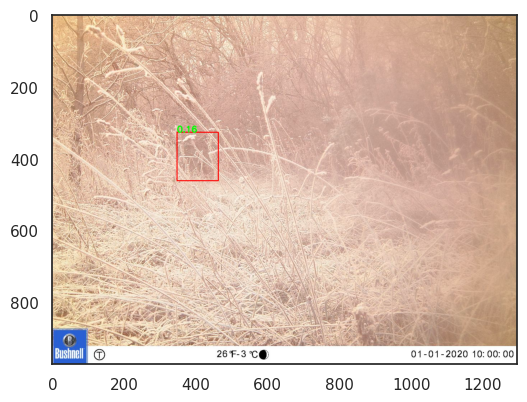

img_name: 30290_01010961.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.977
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.977]
md_confs: [0.16]
score_dict: {'roe_deer': 0.977, 'empty': 0.015, 'others': 0.006, 'red_squirrel': 0.001, 'wild_boar': 0.001, 'european_hare': 0.0, 'red_deer': 0.0, 'red_fox': 0.0}


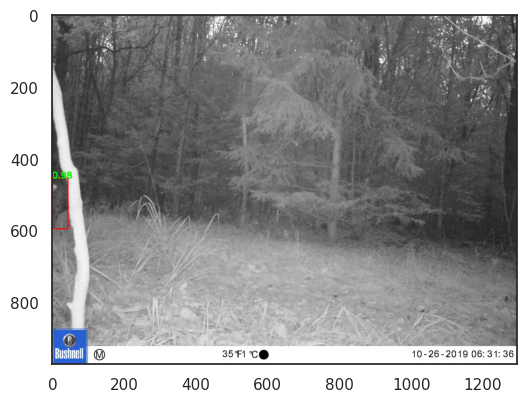

img_name: 46769_10260717.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.978
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.978]
md_confs: [0.98]
score_dict: {'roe_deer': 0.978, 'european_hare': 0.012, 'red_fox': 0.004, 'empty': 0.003, 'others': 0.003, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


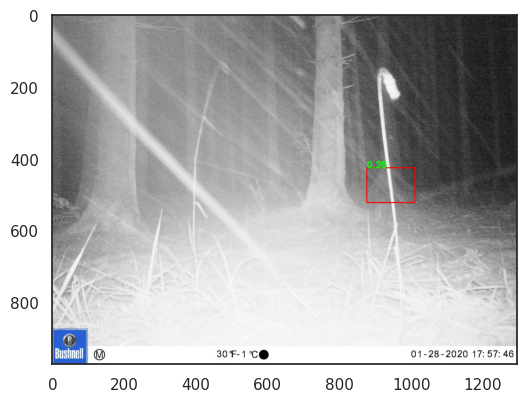

img_name: 55096_01280046.JPG
true_class: empty
pred_class: others
pred_score: 0.407
n_preds: 1
pred_classes: ['others']
pred_confs: [0.407]
md_confs: [0.25]
score_dict: {'others': 0.407, 'empty': 0.343, 'red_fox': 0.169, 'roe_deer': 0.062, 'european_hare': 0.012, 'wild_boar': 0.007, 'red_deer': 0.0, 'red_squirrel': 0.0}


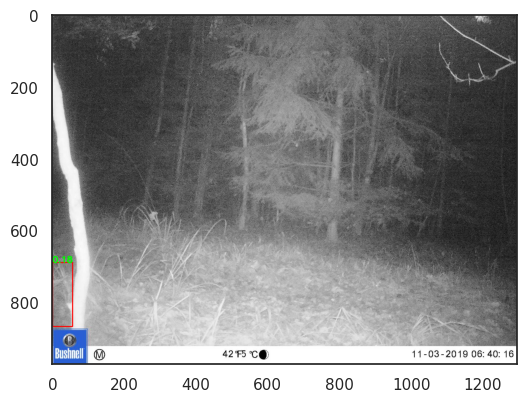

img_name: 50435_11030843.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.64
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.64]
md_confs: [0.18]
score_dict: {'roe_deer': 0.64, 'others': 0.14, 'red_fox': 0.12, 'empty': 0.081, 'european_hare': 0.019, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


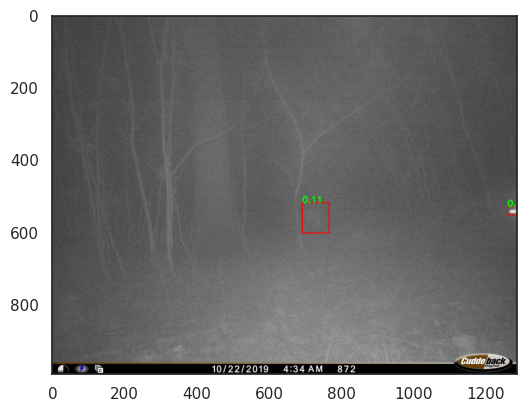

img_name: 30787_I_00067c.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.956
n_preds: 2
pred_classes: ['roe_deer', 'roe_deer']
pred_confs: [0.923, 0.988]
md_confs: [0.11, 0.12]
score_dict: {'roe_deer': 0.956, 'empty': 0.042, 'others': 0.002, 'european_hare': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


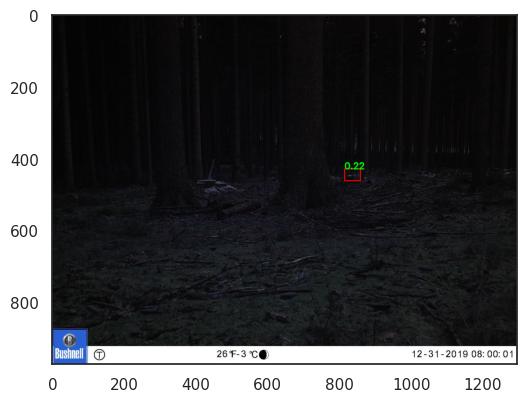

img_name: 4276_12310217.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.528
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.528]
md_confs: [0.22]
score_dict: {'roe_deer': 0.528, 'empty': 0.447, 'others': 0.024, 'european_hare': 0.001, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


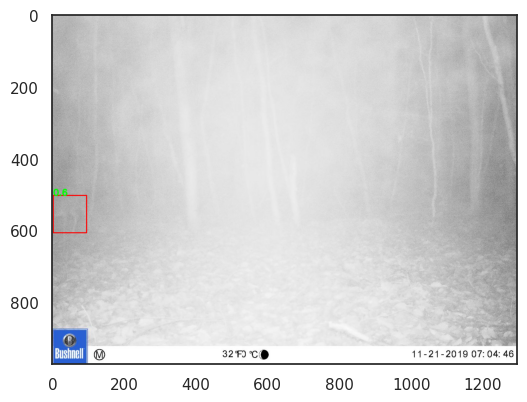

img_name: 8006_11210267.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.98
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.98]
md_confs: [0.6]
score_dict: {'roe_deer': 0.98, 'red_fox': 0.016, 'empty': 0.002, 'others': 0.002, 'european_hare': 0.0, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


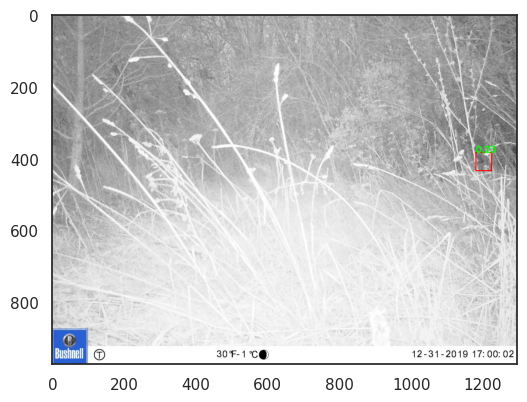

img_name: 30276_12310947.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.537
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.537]
md_confs: [0.23]
score_dict: {'roe_deer': 0.537, 'others': 0.279, 'empty': 0.111, 'european_hare': 0.06, 'red_fox': 0.009, 'wild_boar': 0.002, 'red_squirrel': 0.001, 'red_deer': 0.0}


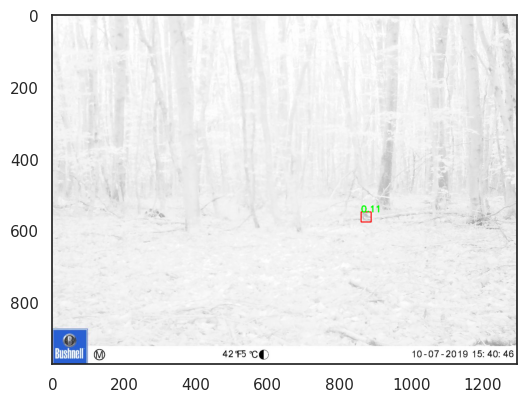

img_name: 7817_10070057.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.883
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.883]
md_confs: [0.11]
score_dict: {'roe_deer': 0.883, 'empty': 0.107, 'others': 0.007, 'red_fox': 0.003, 'european_hare': 0.001, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


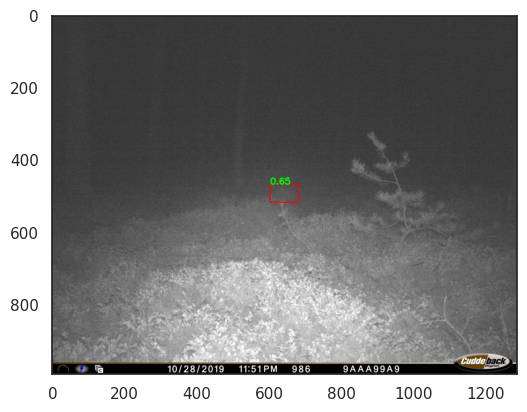

img_name: 39667_I_00116c.JPG
true_class: empty
pred_class: others
pred_score: 0.481
n_preds: 1
pred_classes: ['others']
pred_confs: [0.481]
md_confs: [0.65]
score_dict: {'others': 0.481, 'roe_deer': 0.284, 'empty': 0.232, 'wild_boar': 0.002, 'european_hare': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0}


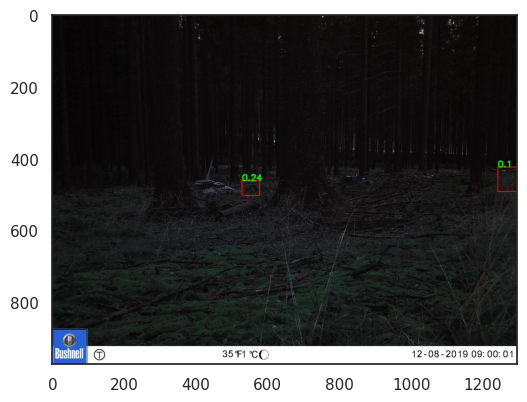

img_name: 7392_12080263.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.602
n_preds: 2
pred_classes: ['roe_deer', 'empty']
pred_confs: [0.602, 0.999]
md_confs: [0.1, 0.24]
score_dict: {'roe_deer': 0.602, 'empty': 0.271, 'others': 0.116, 'wild_boar': 0.009, 'european_hare': 0.001, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0}


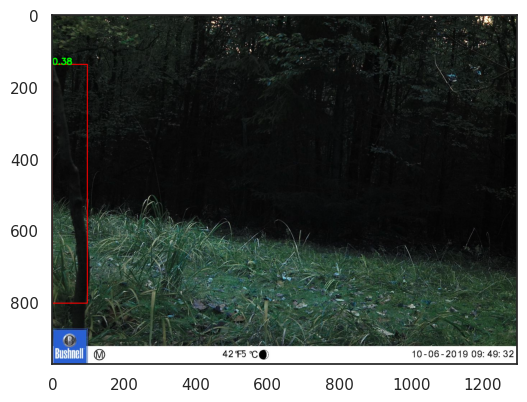

img_name: 48388_10060190.JPG
true_class: empty
pred_class: others
pred_score: 0.927
n_preds: 1
pred_classes: ['others']
pred_confs: [0.927]
md_confs: [0.38]
score_dict: {'others': 0.927, 'empty': 0.068, 'red_squirrel': 0.004, 'roe_deer': 0.001, 'european_hare': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'wild_boar': 0.0}


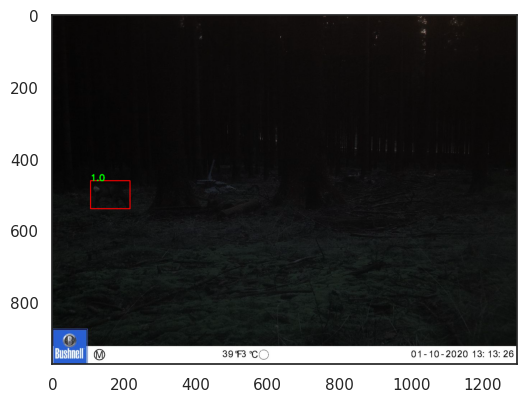

img_name: 7460_01100375.JPG
true_class: empty
pred_class: roe_deer
pred_score: 1.0
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [1.0]
md_confs: [1.0]
score_dict: {'roe_deer': 1.0, 'empty': 0.0, 'european_hare': 0.0, 'others': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


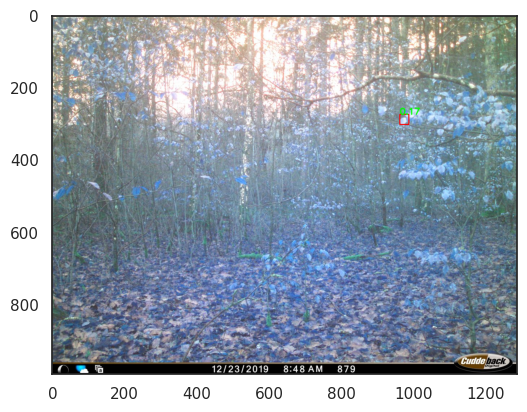

img_name: 9329_I_00412a.JPG
true_class: empty
pred_class: others
pred_score: 0.857
n_preds: 1
pred_classes: ['others']
pred_confs: [0.857]
md_confs: [0.17]
score_dict: {'others': 0.857, 'empty': 0.096, 'roe_deer': 0.038, 'red_fox': 0.006, 'european_hare': 0.001, 'red_deer': 0.001, 'red_squirrel': 0.0, 'wild_boar': 0.0}


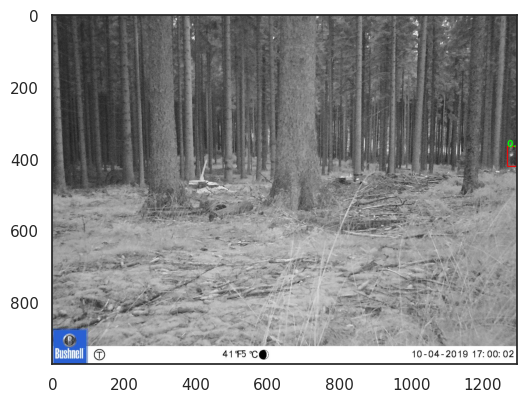

img_name: 5145_10040566.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.517
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.517]
md_confs: [0.11]
score_dict: {'roe_deer': 0.517, 'others': 0.316, 'empty': 0.077, 'wild_boar': 0.059, 'european_hare': 0.021, 'red_fox': 0.008, 'red_deer': 0.001, 'red_squirrel': 0.001}


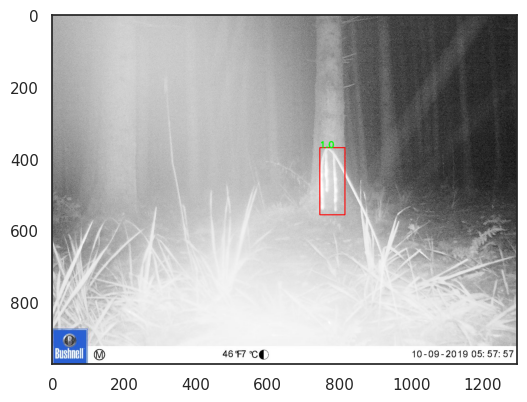

img_name: 108528_10090079.JPG
true_class: empty
pred_class: red_fox
pred_score: 0.892
n_preds: 1
pred_classes: ['red_fox']
pred_confs: [0.892]
md_confs: [1.0]
score_dict: {'red_fox': 0.892, 'others': 0.056, 'empty': 0.03, 'roe_deer': 0.021, 'european_hare': 0.002, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


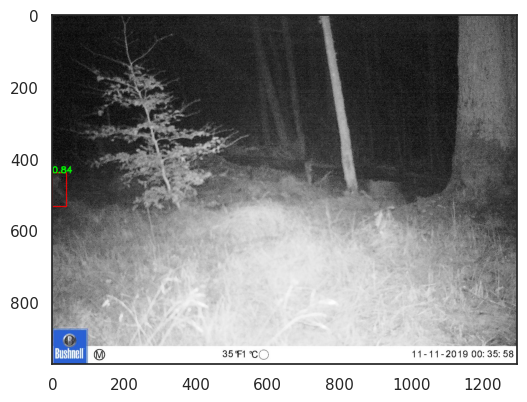

img_name: 11698_11110207.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.67
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.67]
md_confs: [0.84]
score_dict: {'roe_deer': 0.67, 'others': 0.214, 'empty': 0.054, 'wild_boar': 0.043, 'european_hare': 0.018, 'red_fox': 0.001, 'red_deer': 0.0, 'red_squirrel': 0.0}


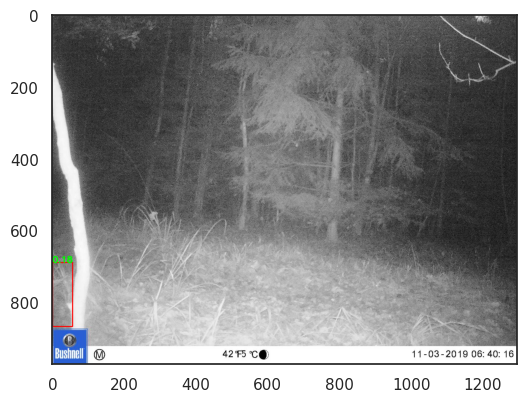

img_name: 50435_11030843.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.64
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.64]
md_confs: [0.18]
score_dict: {'roe_deer': 0.64, 'others': 0.14, 'red_fox': 0.12, 'empty': 0.081, 'european_hare': 0.019, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


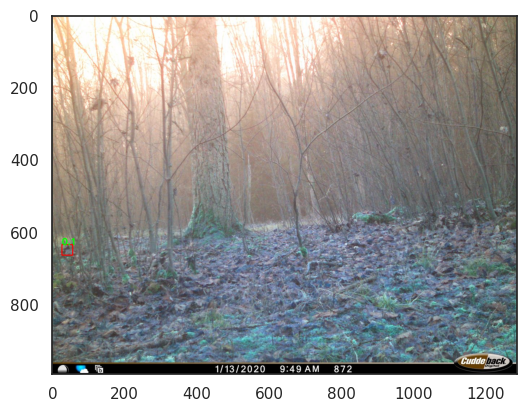

img_name: 31068_I_00146b.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.973
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.973]
md_confs: [0.1]
score_dict: {'roe_deer': 0.973, 'empty': 0.023, 'others': 0.004, 'european_hare': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


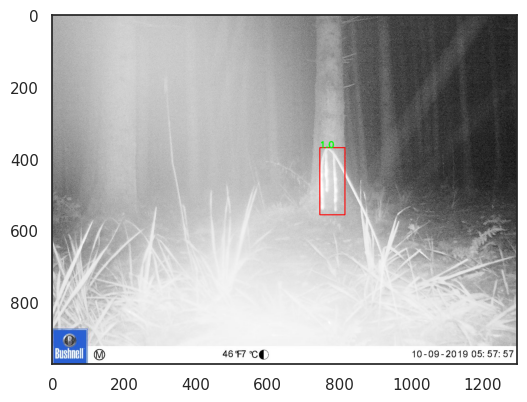

img_name: 108528_10090079.JPG
true_class: empty
pred_class: red_fox
pred_score: 0.892
n_preds: 1
pred_classes: ['red_fox']
pred_confs: [0.892]
md_confs: [1.0]
score_dict: {'red_fox': 0.892, 'others': 0.056, 'empty': 0.03, 'roe_deer': 0.021, 'european_hare': 0.002, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


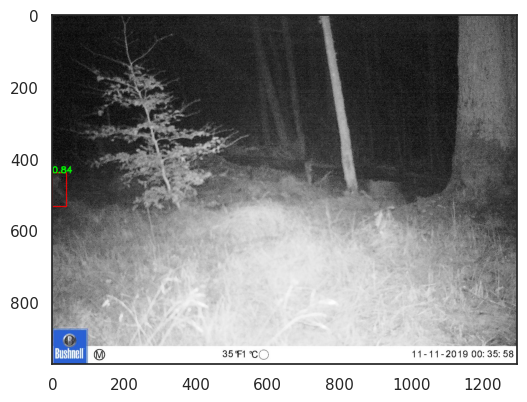

img_name: 11698_11110207.JPG
true_class: empty
pred_class: roe_deer
pred_score: 0.67
n_preds: 1
pred_classes: ['roe_deer']
pred_confs: [0.67]
md_confs: [0.84]
score_dict: {'roe_deer': 0.67, 'others': 0.214, 'empty': 0.054, 'wild_boar': 0.043, 'european_hare': 0.018, 'red_fox': 0.001, 'red_deer': 0.0, 'red_squirrel': 0.0}


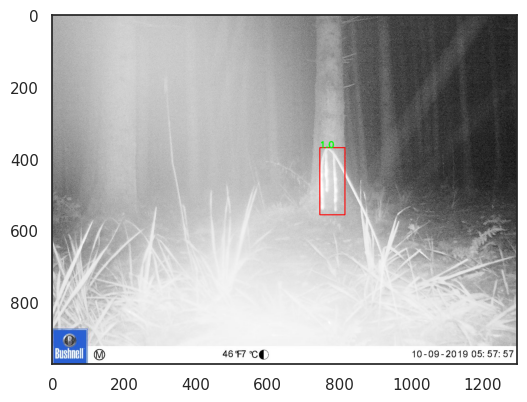

img_name: 108528_10090079.JPG
true_class: empty
pred_class: red_fox
pred_score: 0.892
n_preds: 1
pred_classes: ['red_fox']
pred_confs: [0.892]
md_confs: [1.0]
score_dict: {'red_fox': 0.892, 'others': 0.056, 'empty': 0.03, 'roe_deer': 0.021, 'european_hare': 0.002, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [59]:
#_paper_

# Perhaps show some images
rf.inspect_results(
    df_pred=df_pred, 
    test_label='empty',#'red_deer', 
    label_map=label_map,
    n_displays=25,#5 
    is_truth=True,
    sorting='random',
    which_preds='only_false'#'21526_09270298.JPG',#''mixed',
)


There are 1 available images to be displayed.


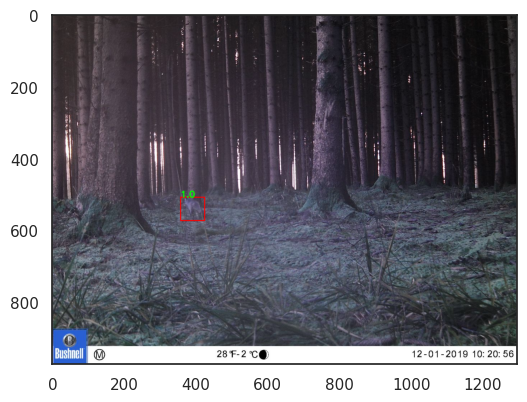

img_name: 109113_12010664.JPG
true_class: empty
pred_class: red_fox
pred_score: 0.761
n_preds: 1
pred_classes: ['red_fox']
pred_confs: [0.761]
md_confs: [1.0]
score_dict: {'red_fox': 0.761, 'roe_deer': 0.179, 'empty': 0.034, 'others': 0.011, 'european_hare': 0.008, 'red_deer': 0.003, 'wild_boar': 0.003, 'red_squirrel': 0.0}


In [53]:
#_paper_

# Perhaps show some images
rf.inspect_results(
    df_pred=df_pred, 
    test_label='empty',#'red_deer', 
    label_map=label_map,
    n_displays=25,#5 
    is_truth=True,
    sorting='random',
    which_preds='109113_12010664.JPG',#''mixed',
)


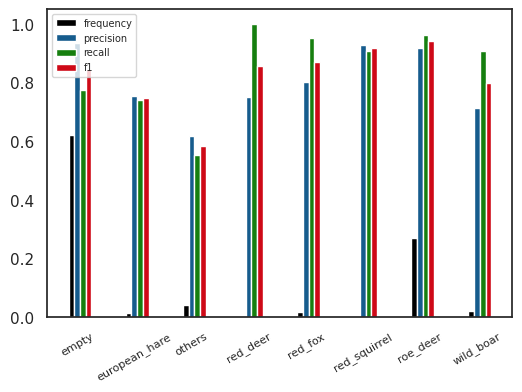

In [12]:
rf.plot_class_performance(
    df_pred=df_pred, 
    df_meta=df_meta, 
    label_map=label_map, 
    ax=None)

# EMPTY VS NON-EMPTY

In [13]:
#_paper_
#Table: rates for 3 different thresholds: 
eval_details_path = 'results/202212062353_insample_empty.pickle'
eval_details_dict = load_pickle(eval_details_path)

thresholds = list(thresholds_dict.values())
names = list(thresholds_dict.keys())

df = pd.DataFrame()
df_pred_list = []

for index_tresh, threshold in enumerate(thresholds):
    
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, label_map)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    df_pred_list.append(df_pred)
    
    conf_md = rf.get_binary_confusion_md(
        dataset=dataset_ins, 
        threshold=threshold, 
        repo_dir=repo_dir,
    )
    conf_ppl = rf.get_binary_confusion_ppl(
        y_true=df_pred['true_class'].map(empty_map), 
        y_pred=df_pred['pred_class'].map(empty_map),
    )
    pref_b = rf.evaluate_performance(
        y_true=df_pred['true_class'].map(empty_map), 
        y_pred=df_pred['pred_class'].map(empty_map), 
        labels=['non_empty', 'empty'], 
        average=None,
    )
    pref_m = rf.evaluate_performance(
        y_true=df_pred['true_class'], 
        y_pred=df_pred['pred_class'], 
        labels=labels, 
        average='macro',
    )
    results = {
        'tnr_md': conf_md.get('tnr'),
        'tpr_md': conf_md.get('tpr'),
        'fnr_md': conf_md.get('fnr'),
        'fpr_md': conf_md.get('fpr'),
        'tnr_ppl': conf_ppl.get('tnr'),
        'tpr_ppl': conf_ppl.get('tpr'),
        'fnr_ppl': conf_ppl.get('fnr'),
        'fpr_ppl': conf_ppl.get('fpr'),
        'acc_b': pref_b.get('acc'),
        'prec_b': pref_b.get('prec')[0],
        'rec_b': pref_b.get('rec')[0],
        'f1_b': pref_b.get('f1')[0],
        'acc_m': pref_m.get('acc'),
        'prec_m': pref_m.get('prec'),
        'rec_m': pref_m.get('rec'),
        'f1_m': pref_m.get('f1'),
    }
    df_x = pd.DataFrame(data=list(results.values()), index=results.keys())
    df = pd.concat([df, df_x.T], axis=0)

df['names'] = names
df = df.set_index('names')
df


tnr_md    tpr_md    fnr_md    fpr_md   tnr_ppl   tpr_ppl  \
names                                                                     
ours         0.375706  0.926211  0.073789  0.624294  0.862179  0.976451   
progressive  0.546218  0.885479  0.114521  0.453782  0.897436  0.962994   
norouzzadeh  0.747126  0.846999  0.153001  0.252874  0.919872  0.947855   

              fnr_ppl   fpr_ppl     acc_b    prec_b     rec_b      f1_b  \
names                                                                     
ours         0.023549  0.137821  0.952698  0.964286  0.976451  0.970330   
progressive  0.037006  0.102564  0.949367  0.972812  0.962994  0.967878   
norouzzadeh  0.052145  0.080128  0.942039  0.978299  0.947855  0.962836   

                acc_m    prec_m     rec_m      f1_m  
names                                                
ours         0.899400  0.829109  0.861376  0.841877  
progressive  0.894737  0.800790  0.854708  0.823690  
norouzzadeh  0.892738  0.836283  0.836179  0.831049

In [14]:
print(df.iloc[:,8:12].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  acc\_b &  prec\_b &  rec\_b &  f1\_b \\
names       &        &         &        &       \\
\midrule
ours        &  0.953 &   0.964 &  0.976 & 0.970 \\
progressive &  0.949 &   0.973 &  0.963 & 0.968 \\
norouzzadeh &  0.942 &   0.978 &  0.948 & 0.963 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2377001/3797367475.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.iloc[:,8:12].to_latex(float_format="%.3f"))


In [15]:
print(df.iloc[:,12:].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  acc\_m &  prec\_m &  rec\_m &  f1\_m \\
names       &        &         &        &       \\
\midrule
ours        &  0.899 &   0.829 &  0.861 & 0.842 \\
progressive &  0.895 &   0.801 &  0.855 & 0.824 \\
norouzzadeh &  0.893 &   0.836 &  0.836 & 0.831 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2377001/171953916.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.iloc[:,12:].to_latex(float_format="%.3f"))


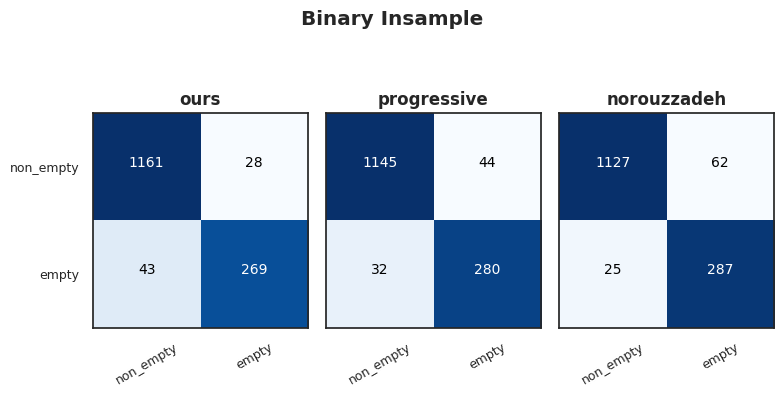

In [16]:
fig, axes = plt.subplots(1,3, figsize=(8, 4), tight_layout=True, sharey=True)

for index_tresh, threshold in enumerate(thresholds):
    ax = axes[index_tresh]
    df_pred = df_pred_list[index_tresh].copy()
    df_pred['true_class'] = df_pred['true_class'].map(empty_map)
    df_pred['pred_class'] = df_pred['pred_class'].map(empty_map)
    rf.inspect_confusion(
        df_pred=df_pred, 
        normalize=False, #True
        labels=['non_empty', 'empty'], 
        ax=ax)
    ax.set_title(names[index_tresh], weight='bold')

plt.suptitle("Binary Insample", weight='bold')
plt.show()
plt.close()

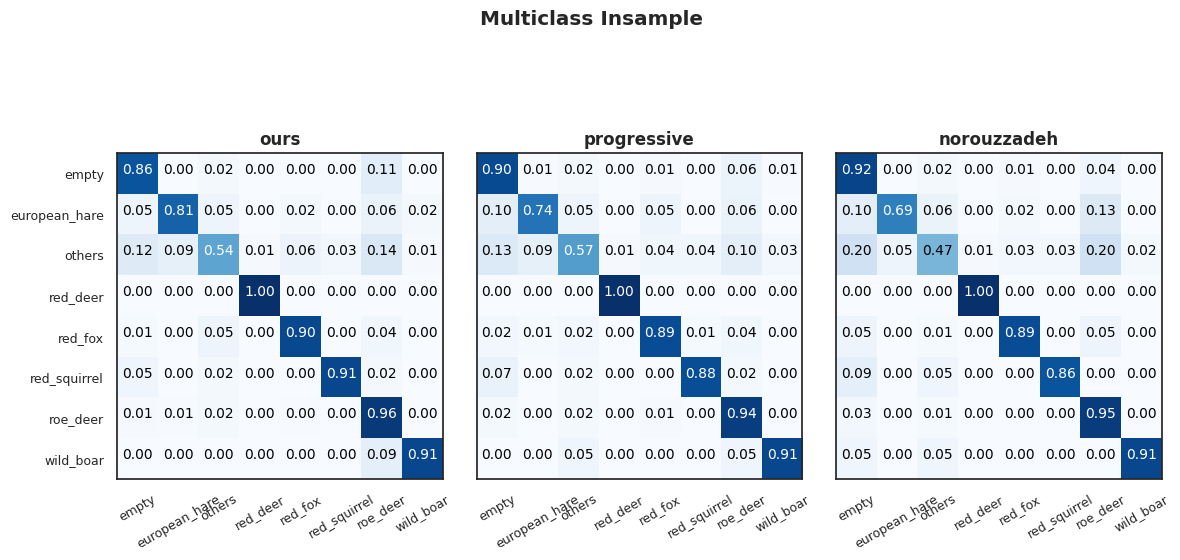

In [17]:
fig, axes = plt.subplots(1,3, figsize=(12, 6), tight_layout=True, sharey=True)

for index_tresh, threshold in enumerate(thresholds):
    ax = axes[index_tresh] 
    rf.inspect_confusion(
        df_pred=df_pred_list[index_tresh], 
        normalize=True, 
        labels=labels, 
        ax=ax)
    ax.set_title(names[index_tresh], weight='bold')
    
plt.suptitle("Multiclass Insample", weight='bold')
plt.show()
plt.close()

In [18]:
index_tresh

2

               precision    recall  f1-score   support

        empty       0.91      0.86      0.88       312
european_hare       0.77      0.81      0.79        62
       others       0.66      0.54      0.60       105
     red_deer       0.75      1.00      0.86         3
      red_fox       0.87      0.90      0.89        82
 red_squirrel       0.91      0.91      0.91        43
     roe_deer       0.93      0.96      0.95       872
    wild_boar       0.83      0.91      0.87        22

     accuracy                           0.90      1501
    macro avg       0.83      0.86      0.84      1501
 weighted avg       0.90      0.90      0.90      1501



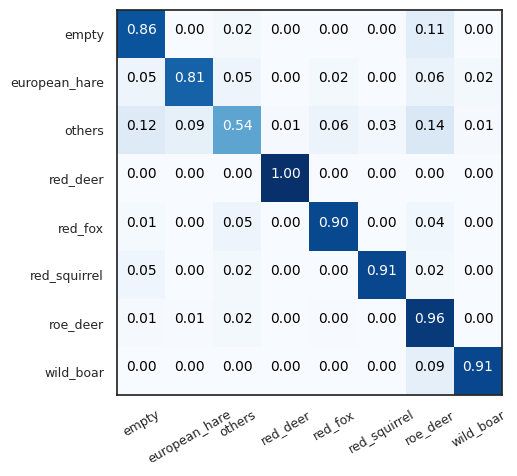

In [20]:
#_paper_
# Table: confusion matrix and recall/precision
report = classification_report(
    y_true=df_pred_list[0]['true_class'], 
    y_pred=df_pred_list[0]['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)
rf.inspect_confusion(
    df_pred=df_pred_list[0], 
    normalize=True, 
    labels=labels, 
    ax=None,
)

In [21]:
#_paper_
#XX% of empty images are correctly detected (TN) 
#only XX% are falsely labeled as empty where in fact they contain animals (FN)
TN = df.loc['ours', 'tnr_ppl'] 
TP = df.loc['ours', 'tpr_ppl'] 
FN = df.loc['ours', 'fnr_ppl']
print(f'{TN:.3}% of empty images are correctly detected')
print(f'{TP:.3}% of non-empty images are correctly detected')
print(f'{FN:.3}% are falsely labeled as empty')

0.862% of empty images are correctly detected
0.976% of non-empty images are correctly detected
0.0235% are falsely labeled as empty


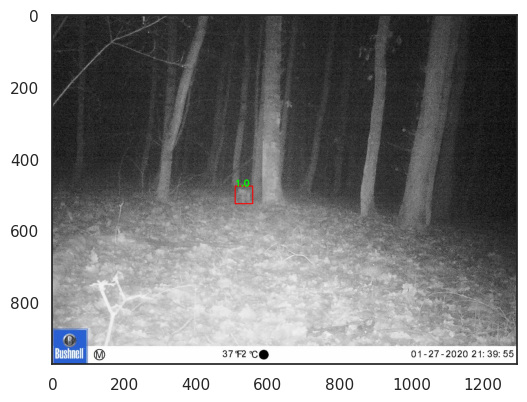

img_name: 18813_01270144.JPG
true_class: non_empty
pred_class: empty
pred_score: 0.583
n_preds: 1
pred_classes: ['empty']
pred_confs: [0.583]
md_confs: [1.0]
score_dict: {'empty': 0.583, 'european_hare': 0.299, 'others': 0.067, 'roe_deer': 0.026, 'red_fox': 0.024, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [17]:
#_paper_
#Figure: some false non-empties
rf.inspect_results(
    df_pred=df_pred, 
    test_label='empty', 
    label_map=label_map,
    n_displays=1, 
    is_truth=False,
    sorting='descending',
    which_preds='only_false',
)

# OUT-OF-SAMPLE

In [26]:
eval_details_path = 'results/202212070005_oosample_perf.pickle'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
df_pred_oos = df_pred.copy()

conf_md = rf.get_binary_confusion_md(
    dataset=dataset_oos, 
    threshold=thresholds_dict['ours'], 
    repo_dir=repo_dir,
)
conf_ppl = rf.get_binary_confusion_ppl(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'],
)
pref_b = rf.evaluate_performance(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
    labels=['non_empty', 'empty'], 
    average=None,
)
pref_m = rf.evaluate_performance(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels, 
    average='macro',
)
results_oos = {
    'tnr_md': conf_md.get('tnr'),
    'tpr_md': conf_md.get('tpr'),
    'fnr_md': conf_md.get('fnr'),
    'fpr_md': conf_md.get('fpr'),
    'tnr_ppl': conf_ppl.get('tnr'),
    'tpr_ppl': conf_ppl.get('tpr'),
    'fnr_ppl': conf_ppl.get('fnr'),
    'fpr_ppl': conf_ppl.get('fpr'),
    'acc_b': pref_b.get('acc'),
    'prec_b': pref_b.get('prec')[0],
    'rec_b': pref_b.get('rec')[0],
    'f1_b': pref_b.get('f1')[0],
    'acc_m': pref_m.get('acc'),
    'prec_m': pref_m.get('prec'),
    'rec_m': pref_m.get('rec'),
    'f1_m': pref_m.get('f1'),
}
results_oos

{'tnr_md': 0.38082901554404147,
 'tpr_md': 0.9212548015364916,
 'fnr_md': 0.07874519846350832,
 'fpr_md': 0.6191709844559585,
 'tnr_ppl': 0.5151515151515151,
 'tpr_ppl': 0.9843166542195668,
 'fnr_ppl': 0.01568334578043316,
 'fpr_ppl': 0.48484848484848486,
 'acc_b': 0.8915518274415818,
 'prec_b': 0.8917456021650879,
 'rec_b': 0.9843166542195668,
 'f1_b': 0.9357472488462903,
 'acc_m': 0.7777112043139605,
 'prec_m': 0.5286769628526444,
 'rec_m': 0.5149794925230261,
 'f1_m': 0.5072121790798158}

               precision    recall  f1-score   support

        empty       0.89      0.52      0.65       330
european_hare       0.66      0.66      0.66        41
       others       0.40      0.30      0.34       120
     red_deer       0.00      0.00      0.00        21
      red_fox       0.41      0.50      0.45        22
 red_squirrel       0.25      0.50      0.33         2
     roe_deer       0.80      0.96      0.87      1020
    wild_boar       0.82      0.69      0.75       113

     accuracy                           0.78      1669
    macro avg       0.53      0.51      0.51      1669
 weighted avg       0.77      0.78      0.76      1669



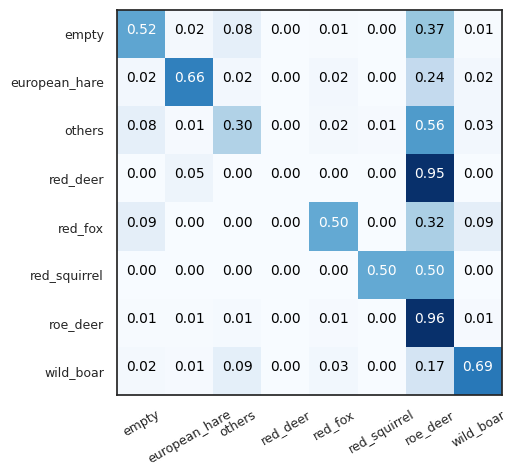

In [27]:
#_paper_

# Table: OOS performance 
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

In [20]:
#_paper_
# Table: compare INS va. OOS (macro averages)

df = pd.DataFrame(index=list(results_ins.keys()))
df['ins']= results_ins.values()
df['oos']= results_oos.values()
df

ins       oos
tnr_md   0.909626  0.894642
tpr_md   0.842142  0.858383
fnr_md   0.157858  0.141617
fpr_md   0.090374  0.105358
tnr_ppl  0.775641  0.515152
tpr_ppl  0.985702  0.984317
fnr_ppl  0.014298  0.015683
fpr_ppl  0.224359  0.484848
acc_b    0.942039  0.891552
prec_b   0.943639  0.891746
rec_b    0.985702  0.984317
f1_b     0.964212  0.935747
acc_m    0.884077  0.777711
prec_m   0.802573  0.528677
rec_m    0.850212  0.514979
f1_m     0.820691  0.507212

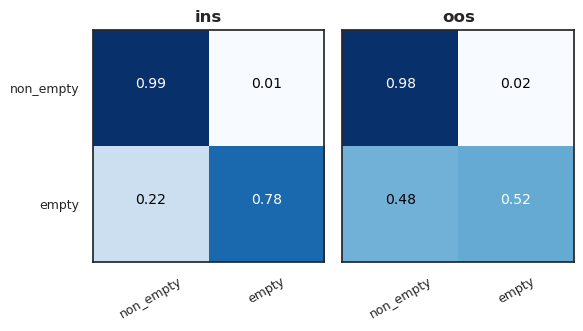

In [21]:
df_pred_ins_b = df_pred_ins.copy()
df_pred_ins_b['true_class'] = df_pred_ins_b['true_class'].map(empty_map)
df_pred_ins_b['pred_class'] = df_pred_ins_b['pred_class'].map(empty_map)

df_pred_oos_b = df_pred_oos.copy()
df_pred_oos_b['true_class'] = df_pred_oos_b['true_class'].map(empty_map)
df_pred_oos_b['pred_class'] = df_pred_oos_b['pred_class'].map(empty_map)


fig, ax = plt.subplots(1, 2, figsize=(6, 4), tight_layout=True, sharey=True)
rf.inspect_confusion(
    df_pred=df_pred_ins_b, 
    normalize=True, 
    labels=['non_empty', 'empty'], 
    ax=ax[0])
ax[0].set_title('ins', weight='bold')

rf.inspect_confusion(
    df_pred=df_pred_oos_b, 
    normalize=True, 
    labels=['non_empty', 'empty'], 
    ax=ax[1])
ax[1].set_title('oos', weight='bold')
plt.show()
plt.close()

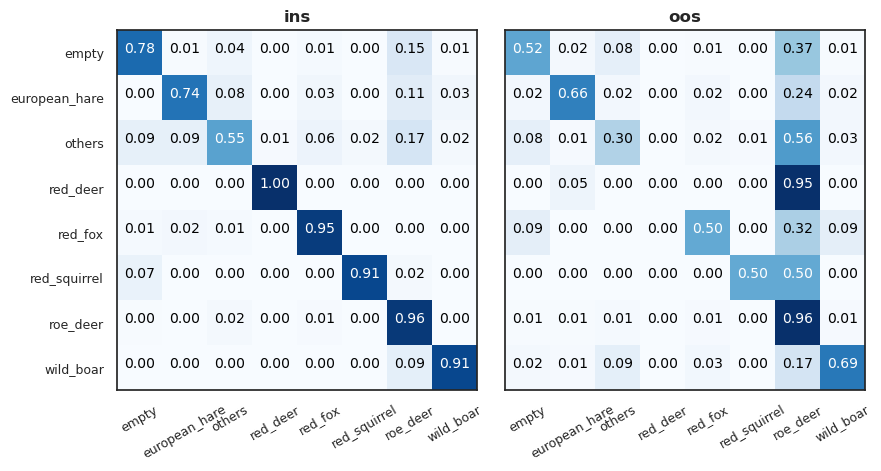

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6), tight_layout=True, sharey=True)
rf.inspect_confusion(
    df_pred=df_pred_ins, 
    normalize=True, 
    labels=labels, 
    ax=ax[0])
ax[0].set_title('ins', weight='bold')

rf.inspect_confusion(
    df_pred=df_pred_oos, 
    normalize=True, 
    labels=labels, 
    ax=ax[1])
ax[1].set_title('oos', weight='bold')
plt.show()
plt.close()